<a href="https://colab.research.google.com/github/Yuumna/GAN-PyTorch/blob/main/GAN_linear_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Generative Adversarial Network - PyTorch**
This notebook contains implementation of normal linear GAN without weight normalization.

# Import Libraries

In [ ]:
#PyTorch dependencies
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
torch.manual_seed(0)

# Download and Transform Data


In [ ]:
batch_size = 128

# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

#GAN Model

# Discriminator

In [ ]:
def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2 
    '''
    return nn.Sequential(
         nn.Linear(input_dim, output_dim), #Layer 1
         nn.LeakyReLU(0.2, inplace=True) #LeakyReLU activation
    )

In [ ]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            # Adding one more linear map to transform the final output into a single value  
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)

# Generator


In [ ]:
def get_generator_block(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.ReLU(inplace=True),
    )

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
      
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)
    

# Instantiate Models

In [ ]:
# If a gpu is available move all models to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#build the models
z_dim = 64
criterion = nn.BCEWithLogitsLoss()

gen = Generator(z_dim).to(device)
disc = Discriminator().to(device) 

In [ ]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2

    return disc_loss

In [ ]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the c1urrent batch
    '''
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))

    return gen_loss

In [ ]:
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples,z_dim,device=device)
  

# **Training**

# optimizer

In [ ]:
lr = 0.00001 #learning_rate

gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 1.1339581944942478, discriminator loss: 0.49955437189340585


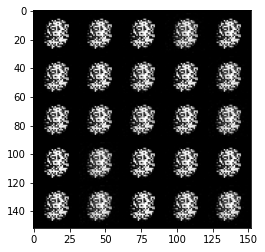

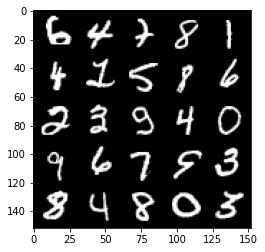

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 1.057752263903618, discriminator loss: 0.5498834177255627


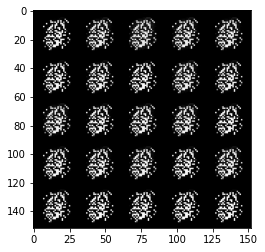

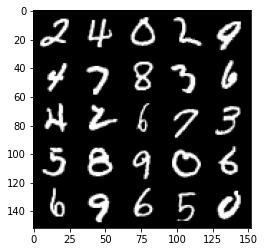

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 1.1106908056735998, discriminator loss: 0.48908046561479557


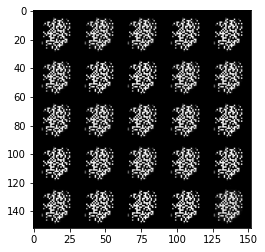

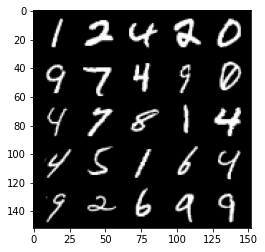

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.3254918558597557, discriminator loss: 0.43731661564111696


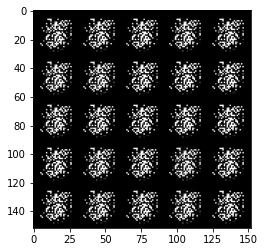

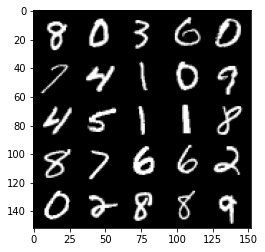

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 1.6086066684722882, discriminator loss: 0.30318301010131826


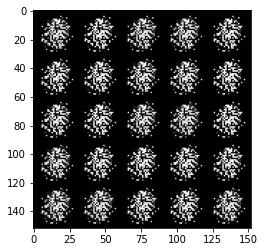

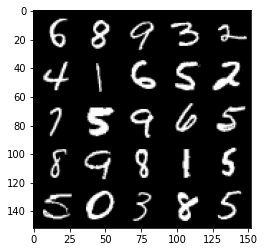

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 1.5194733910560605, discriminator loss: 0.4092124311327935


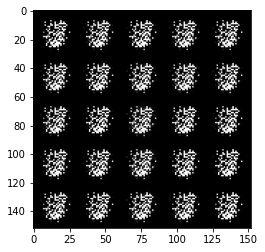

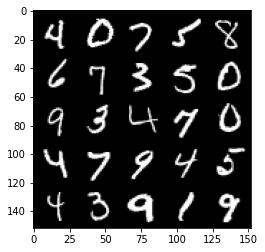

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 1.6977694077491745, discriminator loss: 0.2896355554163455


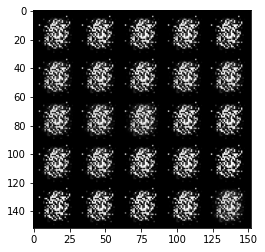

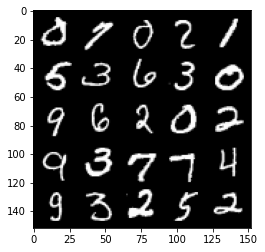

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 1.6550542314052585, discriminator loss: 0.2836050891876224


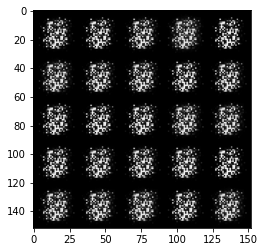

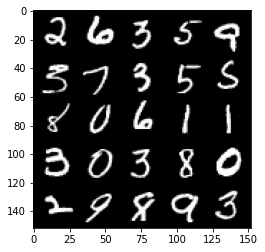

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 1.7172529714107527, discriminator loss: 0.23848075741529465


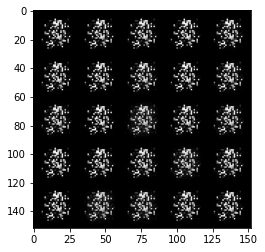

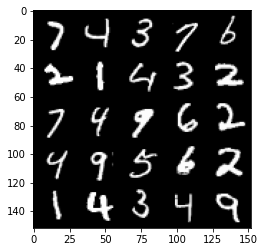

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 1.552326280593872, discriminator loss: 0.2737366997003555


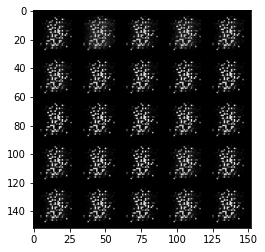

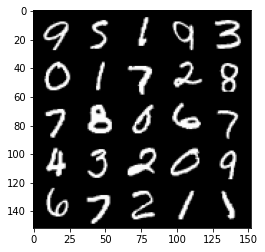

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 1.6366757652759556, discriminator loss: 0.24608927869796748


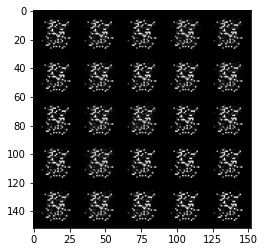

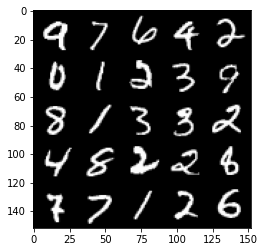

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 2.0831889836788187, discriminator loss: 0.1864761685132979


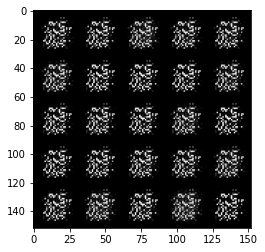

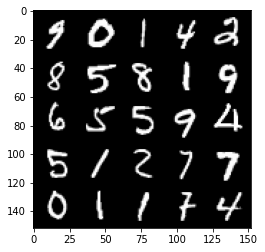

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 2.819982180118562, discriminator loss: 0.08567443254590032


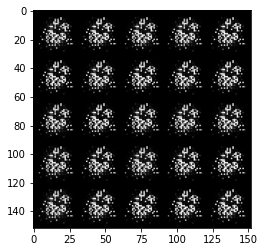

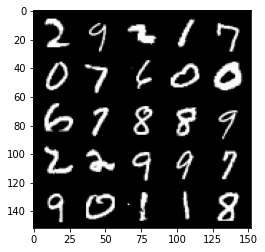

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 3.095816637516024, discriminator loss: 0.08358596188575027


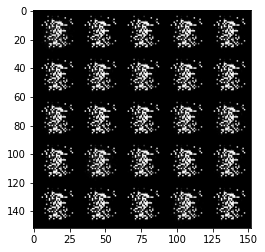

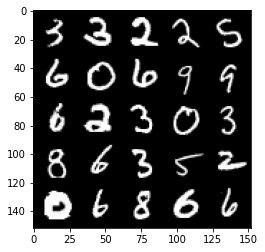

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 3.3987044258117702, discriminator loss: 0.05744873550906777


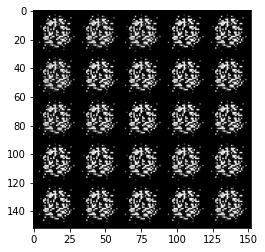

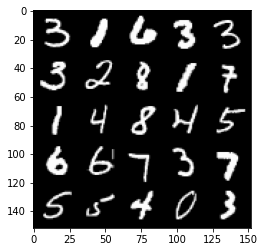

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 3.861941183567048, discriminator loss: 0.04123188474960631


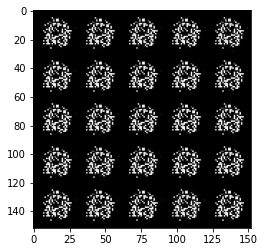

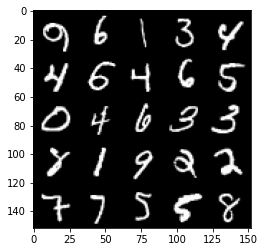

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 4.014729410648349, discriminator loss: 0.028428483698517085


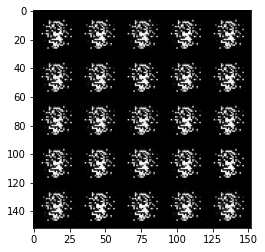

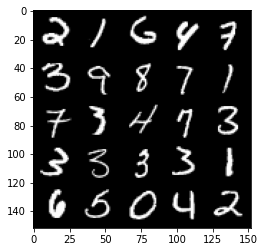

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 3.787145319461821, discriminator loss: 0.0446742918603122


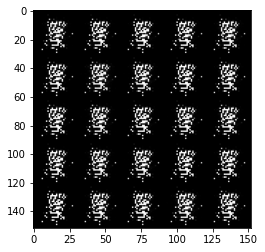

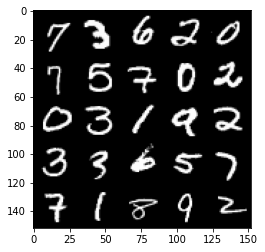

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss: 3.9964051218032837, discriminator loss: 0.03574319233000279


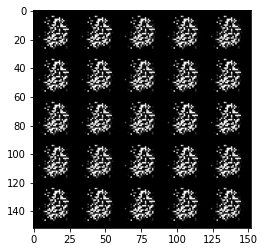

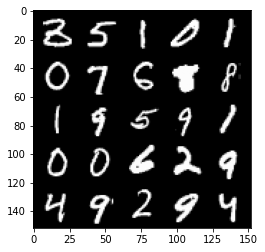

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 4.75910105752945, discriminator loss: 0.015189793175086392


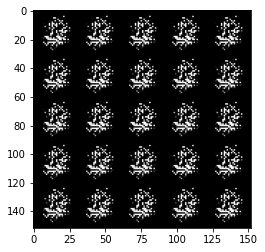

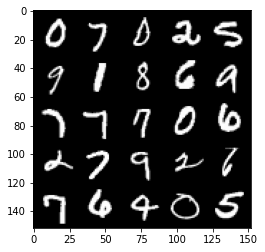

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss: 4.697396037101748, discriminator loss: 0.016275911848060792


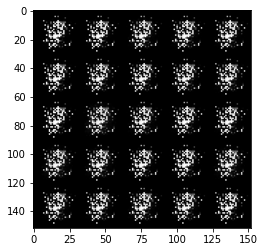

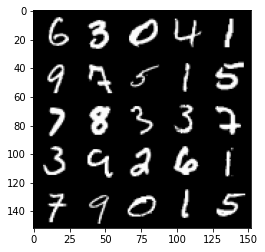

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 4.874612270355224, discriminator loss: 0.014817305178381505


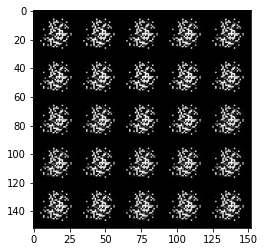

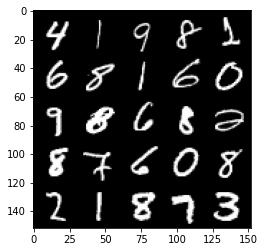

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500: Generator loss: 5.123652350425724, discriminator loss: 0.012158179679419836


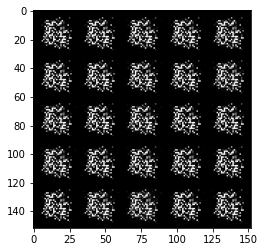

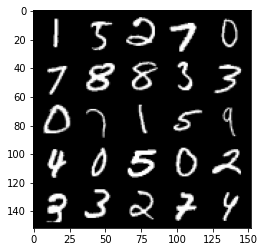

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss: 5.353757660865789, discriminator loss: 0.009859481698833399


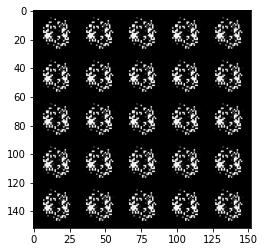

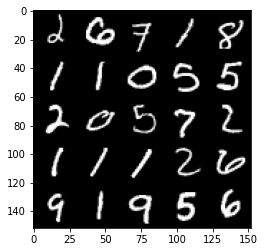

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12500: Generator loss: 5.404031489372255, discriminator loss: 0.012068532139295719


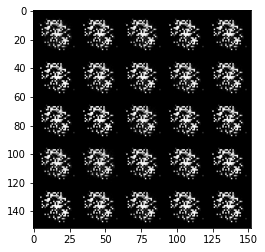

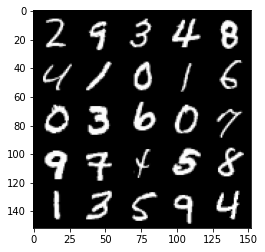

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000: Generator loss: 5.537170575141908, discriminator loss: 0.008446741253836074


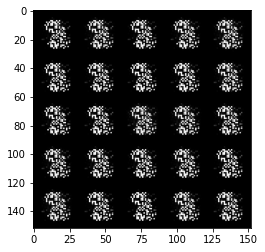

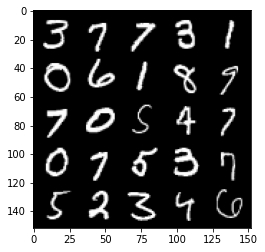

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13500: Generator loss: 5.4682919073104825, discriminator loss: 0.009867949461564426


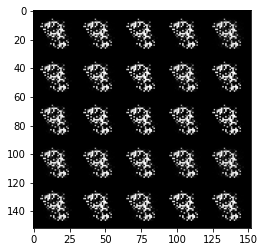

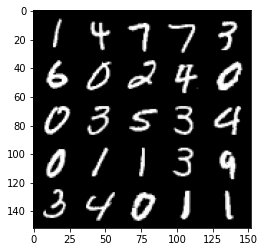

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14000: Generator loss: 5.331578175544738, discriminator loss: 0.011984815907198923


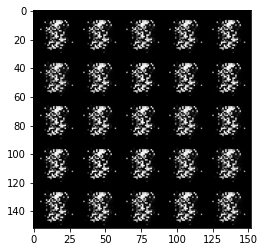

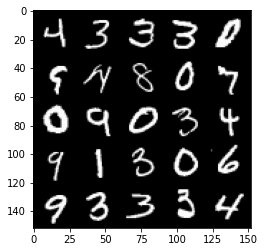

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14500: Generator loss: 5.908701722145084, discriminator loss: 0.006060741552151744


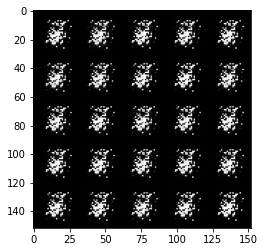

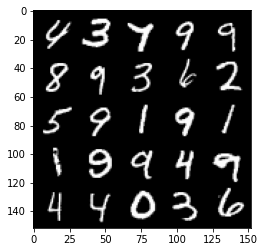

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss: 5.566202284812927, discriminator loss: 0.008468493164051318


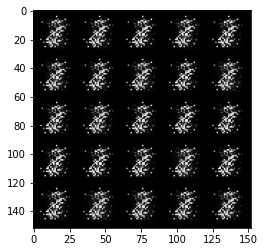

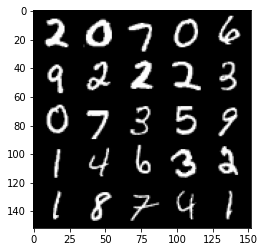

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15500: Generator loss: 5.620803789138788, discriminator loss: 0.010951606548624114


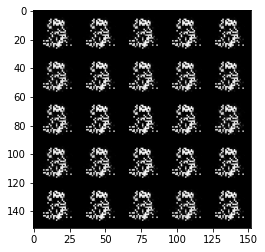

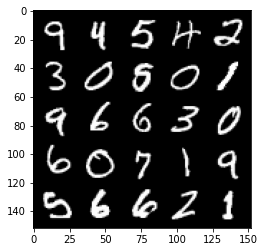

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16000: Generator loss: 5.85396975421906, discriminator loss: 0.007619338728487503


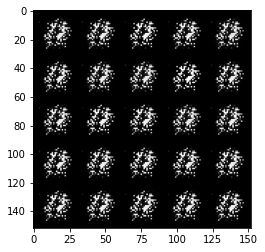

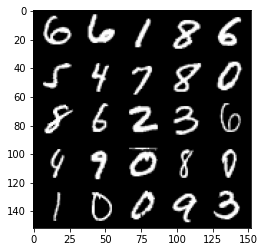

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16500: Generator loss: 5.776524953842165, discriminator loss: 0.008162335676490332


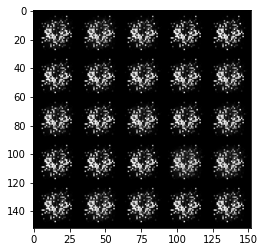

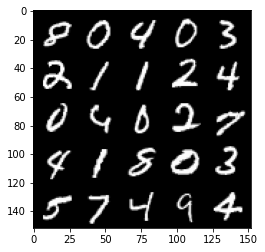

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17000: Generator loss: 6.084802231788631, discriminator loss: 0.008198781904589843


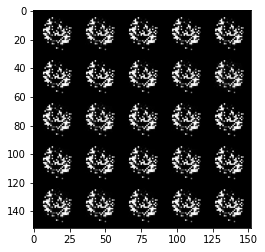

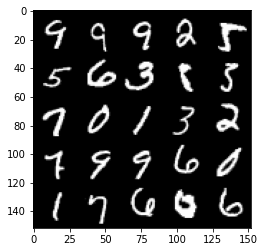

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17500: Generator loss: 6.4302017440795955, discriminator loss: 0.004192148772825022


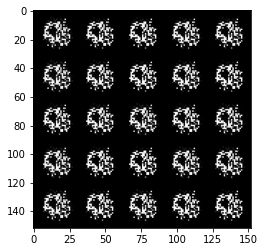

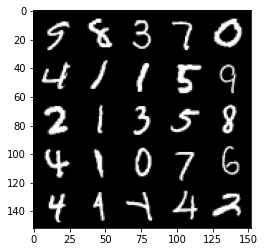

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18000: Generator loss: 6.450319394111634, discriminator loss: 0.006390066425316039


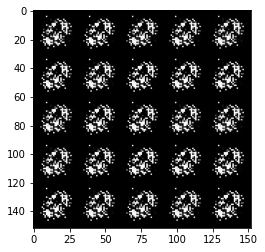

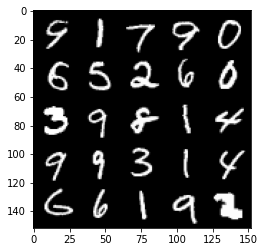

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18500: Generator loss: 6.534586721420286, discriminator loss: 0.003638703979435376


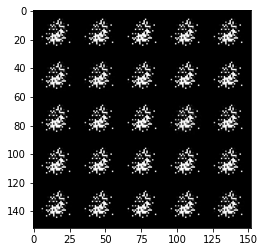

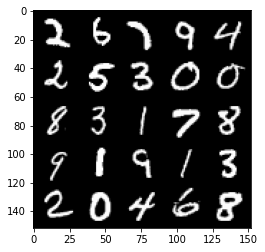

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19000: Generator loss: 6.226430098533635, discriminator loss: 0.006029391792137179


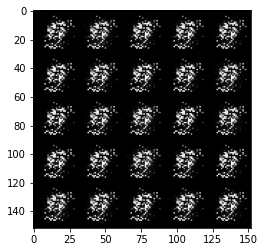

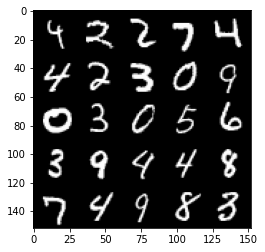

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19500: Generator loss: 6.197983664512635, discriminator loss: 0.0069365286069223665


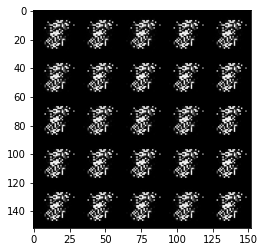

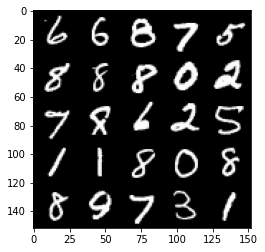

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20000: Generator loss: 6.231735802650458, discriminator loss: 0.005054662874201314


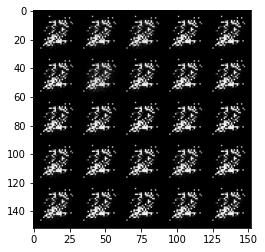

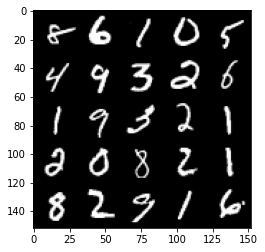

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20500: Generator loss: 6.380880443573, discriminator loss: 0.005137379093212081


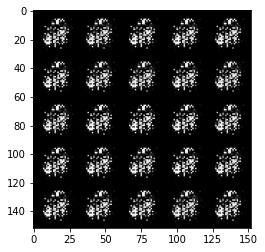

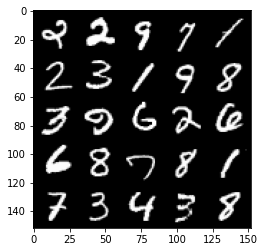

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21000: Generator loss: 6.511320016860961, discriminator loss: 0.004626086354022844


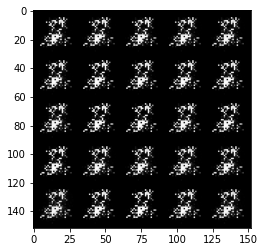

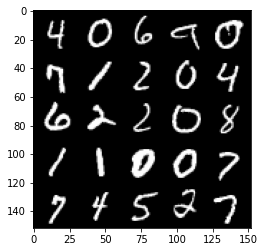

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21500: Generator loss: 6.4224615974426245, discriminator loss: 0.005597205632017


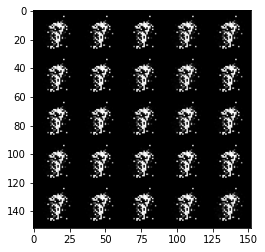

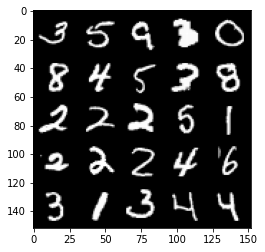

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22000: Generator loss: 6.557162814140317, discriminator loss: 0.005919033276324625


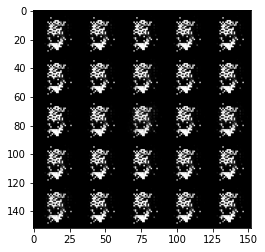

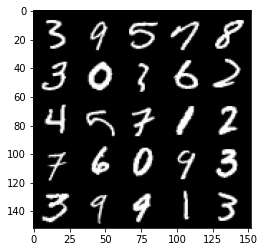

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22500: Generator loss: 6.321061520576482, discriminator loss: 0.005634648374048997


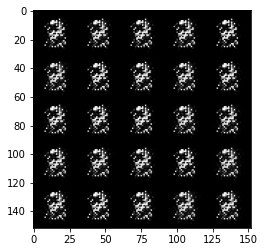

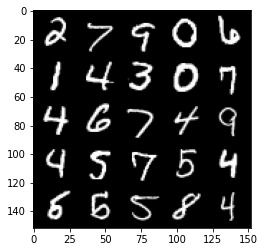

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 23000: Generator loss: 6.333091856002808, discriminator loss: 0.007315387083683156


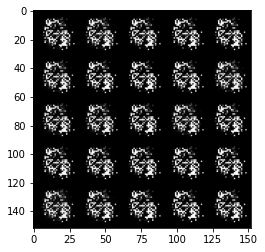

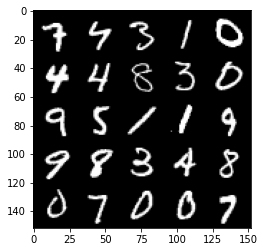

In [ ]:
n_epochs = 50
display_step = 500
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

# Keep track of losses
disc_losses = []
gen_losses = []

test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        # Zero out the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        disc_losses.append(disc_loss.item())

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_losses.append(gen_loss.item())
        gen_loss.backward()
        gen_opt.step()

        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1


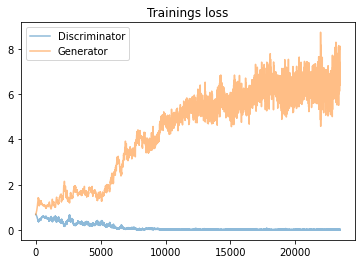

In [ ]:
plt.plot(disc_losses, label="Discriminator", alpha=0.5)
plt.plot(gen_losses, label="Generator", alpha=0.5)
plt.title("Trainings loss")
plt.legend()
plt.show()